In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import ot
import ot.plot
import time
import scipy as sp

from solvers import solvers_L2_UOT as sl2
from solvers import solver_semirelax_L2_UOT as srl2

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

### Load datasets and compose the training and test sets

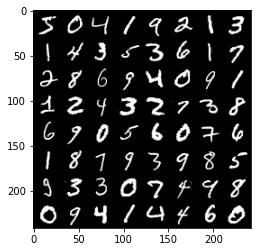

In [2]:
#put download=True in the following instructions to download the dataset 
transform = transforms.Compose([transforms.ToTensor()])
data_train = datasets.MNIST(root="./data/",train=True,transform=transform, download=False)
data_test = datasets.MNIST(root="./data/",train=False,transform=transform, download=False)
data_loader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size=64, shuffle=False)
data_loader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size=64, shuffle=False)
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)
img = img.numpy().transpose(1,2,0)
plt.imshow(img)
plt.show()

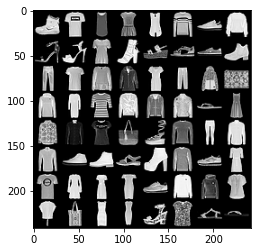

In [3]:
#put download=True in the following instructions to download the dataset 
fashion_train = torchvision.datasets.FashionMNIST("./data", download=False, transform=
                                                transforms.Compose([transforms.ToTensor()]))
fashion_test = torchvision.datasets.FashionMNIST("./data", download=False, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
data_loader_train = torch.utils.data.DataLoader(dataset=fashion_train, batch_size=64, shuffle=False)
data_loader_test = torch.utils.data.DataLoader(dataset=fashion_test, batch_size=64, shuffle=False)

images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)
img = img.numpy().transpose(1,2,0)
plt.imshow(img)
plt.show()

In [4]:
np.random.seed(1)

fashion_train = (fashion_train.train_data, fashion_train.train_labels)
fashion_test = (fashion_test.train_data, fashion_test.train_labels)
images_fashion_train = fashion_train[0].numpy()
labels_fashion_train = fashion_train[1].numpy()
images_fashion_test = fashion_test[0].numpy()
labels_fashion_test = fashion_test[1].numpy()

mnist_train = (data_train.train_data, data_train.train_labels)
mnist_test = (data_test.train_data, data_test.train_labels)
images_train = mnist_train[0].numpy()
labels_train = mnist_train[1].numpy()
images_test = mnist_test[0].numpy()
labels_test = mnist_test[1].numpy()

### Useful functions

In [5]:
def make_subsets(images, labels, list_of_labels, nb_points_per_class):
    if type(nb_points_per_class) == int:
        nb_points_per_class = [nb_points_per_class] * len(list_of_labels)
    perm = []
    for l in range(len(list_of_labels)):
        idx = np.where(labels == list_of_labels[l])[0]
        np.random.seed(1)
        idx_sel = np.random.permutation(len(idx))[:nb_points_per_class[l]]
        perm = perm + idx[idx_sel].tolist()
    return images[perm].reshape(-1, 28 * 28), labels[perm]

def compute_error(G, source_label, target_label, thres=0.5):
    pt_assigned = 0
    pt_correct = 0
    pt_mutual = np.sum(source_label == target_label)
    class_mutual = list(set(source_label) & set(target_label))
    for j in range(np.shape(G)[1]):
        i = np.argmax(G[:,j])
        if np.sum(G[:,j]) > thres / G.shape[1]: 
            pt_assigned += 1
            if source_label[i] == target_label[j]:
                pt_correct += 1
    return pt_assigned, pt_correct

### UOT experiment: only half of the classes are in common in the training and test set

In [6]:
nb_samples = 100
list_labels_source_mnist = [0, 1, 2, 3]
list_labels_target_mnist = [0, 1]
list_labels_target_fashion = [8, 9]
mass_in_common = len(list(set(list_labels_source_mnist) & set(list_labels_target_mnist + list_labels_target_fashion))) * nb_samples

train_mnist_x, train_mnist_l = make_subsets(images_train, labels_train, list_labels_source_mnist, nb_samples)
test_mnist_x, test_mnist_l = make_subsets(images_train, labels_train, list_labels_target_mnist, nb_samples)
test_fashion_x, test_fashion_l = make_subsets(images_fashion_train, labels_fashion_train, list_labels_target_fashion, nb_samples)

train_x = train_mnist_x
test_x = np.concatenate((test_mnist_x, test_fashion_x))
list_labels_source = train_mnist_l
list_labels_target = np.concatenate((test_mnist_l, test_fashion_l))

a = ot.unif(nb_samples * len(list_labels_source_mnist))
b = ot.unif(nb_samples * len(list_labels_source_mnist))
C = sp.spatial.distance.cdist(train_x, test_x)
C = C / C.max()

_, _, T_list, _, _ = sl2.ot_ul2_reg_path(a, b, C, savePi=True)

res_overall_all = []
pt_assigned_all = []
for T in T_list:
    pt_assigned, pt_correct = compute_error(T.toarray(), list_labels_source, list_labels_target, thres=0.25)
    res_overall_all.append(pt_correct)
    pt_assigned_all.append(pt_assigned)


### Draw figure 4

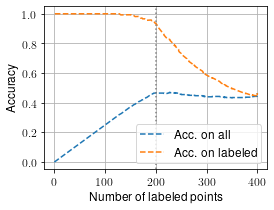

In [8]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "pdf.fonttype": 42,
    "ps.fonttype": 42, 
    "font.size": 12})

plt.figure(figsize=(4, 3))
plt.plot(pt_assigned_all, np.array(res_overall_all)/len(test_x), "--", label="Acc. on all")
plt.plot(pt_assigned_all, np.array(res_overall_all)/(np.array(pt_assigned_all)), "--", label="Acc. on labeled")
plt.ylabel("Accuracy")
plt.xlabel("Number of labeled points")
plt.axvline(x=mass_in_common, color='Grey', linestyle='dotted')
plt.legend()
plt.grid()
#plt.savefig('Classif_expe.pdf', bbox_inches='tight', pad_inches=0) 
plt.savefig('Classif_expe.jpg', bbox_inches='tight', pad_inches=0) 
plt.show()